### Random baseline (Change dataset and splits)

In [8]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

In [9]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [10]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):

    comparisons = pd.DataFrame()
    comparisons[date_col] = forecast[date_col]
    actual = []
    pred = []

    for i in range(len(forecast)):
        pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
        actual.append(forecast[actual_col].values[i][hours_out - 1])

    comparisons['actual'] = actual
    comparisons['pred'] = pred

    return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df

def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):

    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list

def dual_plots(dataset, trainer, data_split, model_type):

    df = construct_output_df(dataset, trainer)
    df["error"] = df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)

    preds = compare_forecast(df, "date", "prediction", "actual", 24)

    ax_comparison_plot = preds.plot(x="date", y=["actual", "pred"], figsize=(20,5), title=f"Comparing predictions v/s actual using {model_type} model on {data_split} SET", style=["-", "--"],              # solid for actual, dashed for pred
    color=["red", "blue"])
    ax_err_plot = df.plot(x="date", y=["error"], figsize=(25, 5), title=f"Error per sample on the {data_split} set using {model_type} model")
    ax_err_plot.axhline(y=df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {df['error'].mean():.3f}")
    ax_err_plot.legend(["Mean Squared Error"], loc="upper right", fontsize=12)
    
    if PLOT_DIR is not None:
        plot_file3 = f"{data_split}_{model_type}.pdf"
        plot_file4 = f"{data_split}_error_{model_type}.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig3 = ax_comparison_plot.get_figure()
        fig3.savefig(os.path.join(PLOT_DIR, plot_file3))

        fig4 = ax_err_plot.get_figure()
        fig4.savefig(os.path.join(PLOT_DIR, plot_file4))



In [11]:
# Set seed for reproducibility
seeds = [44, 88, 22]
# SEED = 88

# set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64
# timestamp_column = "timestamp"
timestamp_column = "date"
TARGET_DATASET = "traffic"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"
dataset_path = "/Users/shivanitomar/Documents/Implementations/FM_TUNE/fm-tune/datasets/traffic/traffic.csv"
# dataset_path = "/Users/shivanitomar/Documents/Implementations/SD_forger/FMforTS/data/monash_exchange_rate.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"


# columns
id_columns = []
target_columns = ['OT']
# target_columns = ['currency_4']
# split_config = {
#     "train": [0, 8640],
#     "valid": [8640, 11520],
#     "test": [
#         11520,
#         14400,
#     ],
# }
# split config for ETTm1/m2
# split_config = {
#     "train": [0, 34560],
#     "valid": [34560, 46080],
#     "test": [
#         46080,
#         57600,
#     ],
# }

# for datasets - Exchange_rate and traffic
split_config = {
    "train": 0.7, 
    "test": 0.2
}

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}
tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config
    )
print("Length of the train/val/test splits are as follows : ", len(dset_train), len(dset_valid), len(dset_test))

Length of the train/val/test splits are as follows :  11673 1661 3413


INFO:p-37524:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


************************************************************************************************************************
Running experiments for seed: 44


INFO:p-37524:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-37524:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Allowed % of predictions that can be discarded : 0.2
Allowed number of samples to be discarded : 682


discarding loop complete


INFO:p-37524:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


************************************************************************************************************************
Running experiments for seed: 88


INFO:p-37524:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-37524:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Allowed % of predictions that can be discarded : 0.2
Allowed number of samples to be discarded : 682


discarding loop complete


INFO:p-37524:t-8327335808:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


************************************************************************************************************************
Running experiments for seed: 22


INFO:p-37524:t-8327335808:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-37524:t-8327335808:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Allowed % of predictions that can be discarded : 0.2
Allowed number of samples to be discarded : 682


discarding loop complete


Results saved to: results/traffic/results_all_seeds.csv


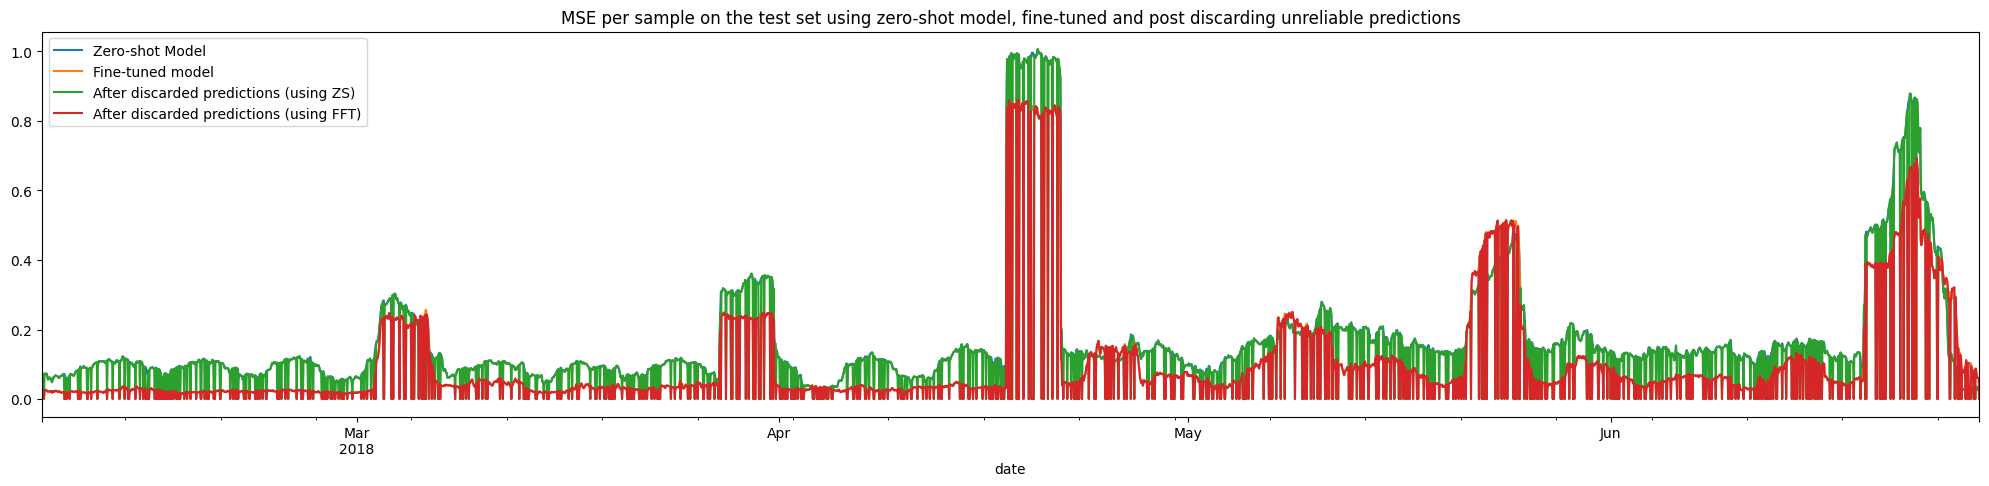

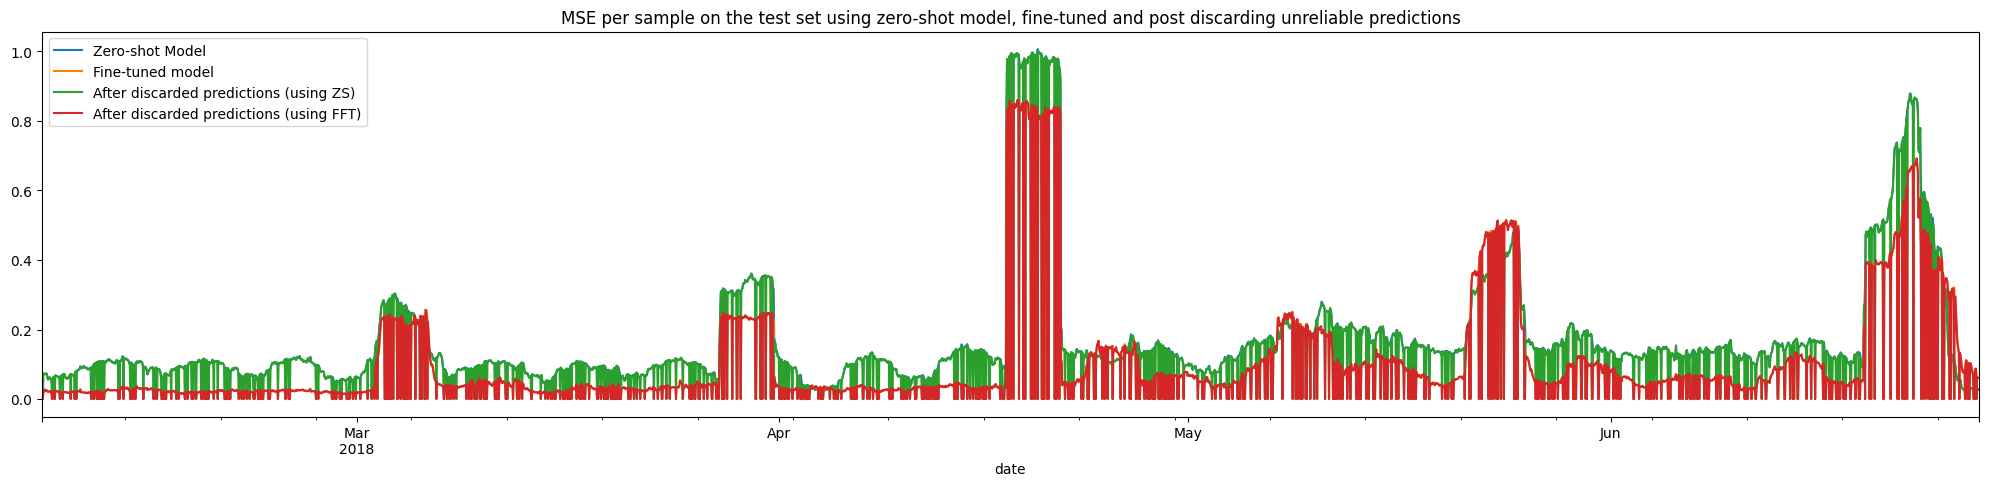

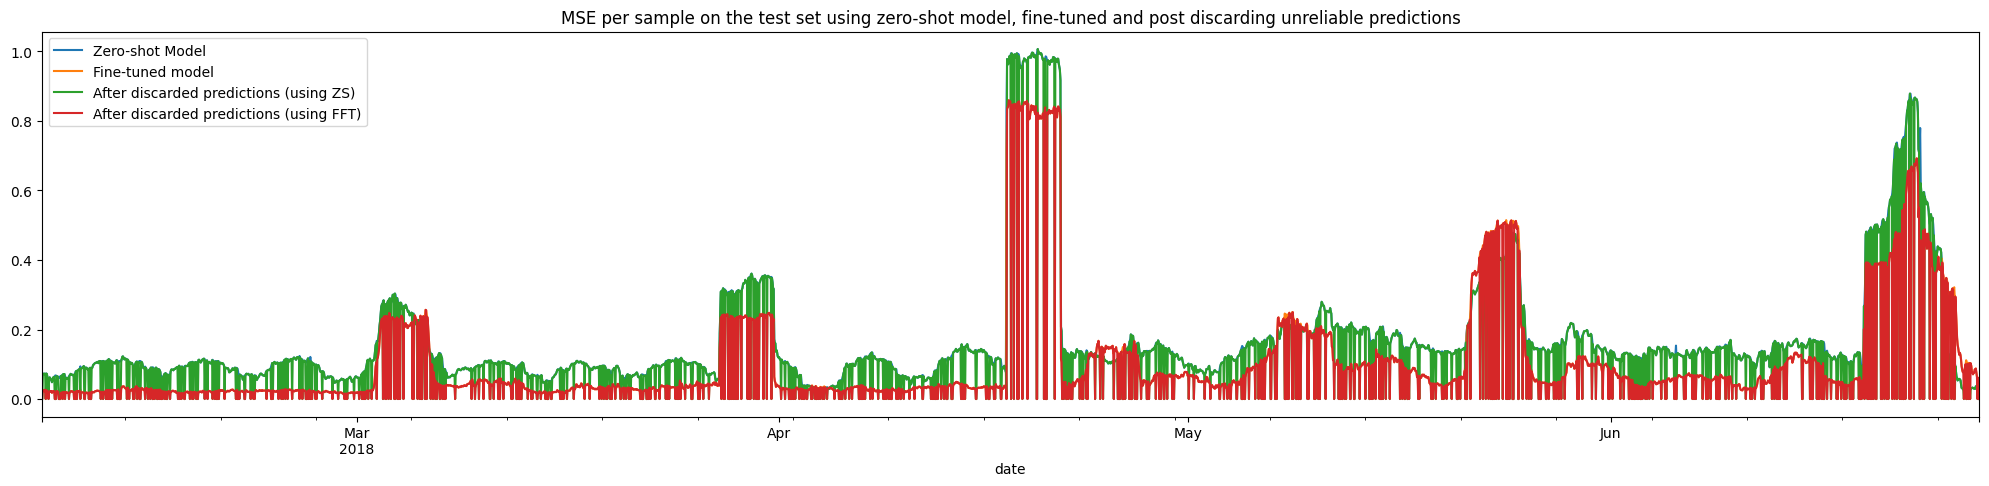

In [12]:
results = []
results_df_dir = f"results/{TARGET_DATASET}"
for SEED in seeds:
    
    print("*" * 120)
    print(f"Running experiments for seed:", SEED)

    RES_DIR = f"results/{TARGET_DATASET}/seed_{SEED}"
    PLOT_DIR = f"plots/{TARGET_DATASET}/seed_{SEED}"
    

    # zero-shot model 
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        prediction_channel_indices=tsp.prediction_channel_indices,
        num_input_channels=tsp.num_input_channels
    )
    
    temp_dir = tempfile.mkdtemp()
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=BATCH_SIZE,
            seed=SEED,
            report_to="none",
        ),
    )
    

    # *******************************************************************************************************
    # loading the fine-tuned model
    fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/AAAI2026/ttm_finetuned_models/traffic/v1_fft/checkpoint-24820")
    temp_dir = tempfile.mkdtemp()

    fft_trainer = Trainer(
            model=fft_model,
            args=TrainingArguments(
                output_dir=temp_dir,
                per_device_eval_batch_size=64,
                seed=SEED,
                report_to="none",
            ),
        )
    fft_test_df = construct_output_df(dset_test, fft_trainer)
    fft_test_df["error"] = fft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)


    

    # User defined drop percentage to discard the number of predictions leading to high error
    percent = 0.2
    drop_limit = int(percent * len(dset_test))
    print("Allowed % of predictions that can be discarded :", percent)
    print("Allowed number of samples to be discarded :", drop_limit)

    np.random.seed(SEED)
    random_indices = np.random.choice(len(dset_test), size=drop_limit, replace=False)
    # print(random_indices)   


    # import warnings
    # distance

    total_error_zs = []
    total_error_fft = []

    for i in range(len(dset_test)):
        if i in random_indices:
            # print("Discarding the sample due to high similarity with one of the shapelets")
            dis = 0
            total_error_zs.append(dis)
            total_error_fft.append(dis)

        else:
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore")

            # using zs model to predict the remaining test samples
            zs_preds_dict = zeroshot_trainer.predict([dset_test[i]])
            zs_preds = zs_preds_dict.predictions[0]
            zs_preds = zs_preds.squeeze(0)
            actual = np.array(dset_test[i]["future_values"])
            zs_error = mean_squared_error(zs_preds, actual)
            total_error_zs.append(zs_error)

            # using the fft model to predict the remaining test samples
            fft_preds_dict = fft_trainer.predict([dset_test[i]])
            fft_preds = fft_preds_dict.predictions[0]
            fft_preds = fft_preds.squeeze(0)
            fft_error = mean_squared_error(fft_preds, actual)
            total_error_fft.append(fft_error)

    print("discarding loop complete")

    # Error after discarding allowed unreliable predictions
    # print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
    discard_df = pd.DataFrame(total_error_zs, columns=["zs_error"])

    
    discard_df["fft_error"] = total_error_fft



    # plotting the same two plots for test set

    # dual_plots(dataset=dset_test, trainer=zeroshot_trainer, data_split="TEST", model_type="zero-shot")

    zs_test_df = construct_output_df(dset_test, zeroshot_trainer)
    zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
    discard_df['date'] = zs_test_df["date"]

    
    # plotting 2 cases : 1. plot showing discarded close matching samples and using ZS model for remaining predictions.
    #                    2. plot showing discarded close matching samples and using FT model for remaining predictions.


    ax_final = zs_test_df.plot(
        x="date",
        y="error",
        figsize=(25, 5),     
        label="Zero-shot Model",
        title="MSE per sample on the test set using zero-shot model, fine-tuned and post discarding unreliable predictions"
    )

    fft_test_df.plot(
        x="date",
        y="error",
        ax=ax_final,
        label="Fine-tuned model"

    )


    discard_df.plot(
        x="date",
        y="zs_error",
        ax=ax_final,
        label="After discarded predictions (using ZS)"

    )

    discard_df.plot(
        x="date",
        y="fft_error",
        ax=ax_final,
        label="After discarded predictions (using FFT)"

    )
    if PLOT_DIR is not None:
        plot_final = "final_comparison_plot.pdf"
        os.makedirs(PLOT_DIR, exist_ok=True)
        fig_final = ax_final.get_figure()
        fig_final.savefig(os.path.join(PLOT_DIR, plot_final))
    
    # Store results
    results.append({
        "seed": SEED,
        "zs_error": np.mean(zs_test_df["error"]),
        "fft_error": np.mean(fft_test_df["error"]),
        "discard_using_zs": np.mean(discard_df["zs_error"]),
        "discard_using_fft": np.mean(discard_df["fft_error"])
        # "discard_using_random"
    })

results_df = pd.DataFrame(results)
# results_df
results_filename = "results_all_seeds.csv"
os.makedirs(results_df_dir, exist_ok=True)
results_path = os.path.join(results_df_dir, results_filename)
results_df.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

In [7]:
results_df

,seed,zs_error,fft_error,discard_using_zs,discard_using_fft
0,44,0.079036,0.077632,0.063172,0.062166
1,88,0.079036,0.077632,0.063640,0.062421
2,22,0.079036,0.077632,0.060914,0.060127
